# Place cell activity from the Buzsáki lab  
homepage: https://buzsakilab.com/wp/  
source: https://crcns.org/data-sets/hc/hc-11/about-hc-11  
mouse name: Achilles

### About the data
For detailed information please follow the link above. In brief, the rat was running back and forth on a linear track for reward. The activity of multiple hippocampal neurons have been recorded together with the position of the animal. 

The hippocampus is a brain region involved in spatial navigation. The task demands are fundementally different during movement versus immobile periods. Accordingly, the hippocampal neuronal activity is different during locomotion than during stops. Therefore the data should be analysed separately for locomotion and stops. 

In the original experiment neuronal activity during a short sleep episode before and after the navigation task (maze epoch) was also recorded. Here we selected data during maze epochs (no pre and post sleep). Spike times and positions are measured in second and meter, respectively. Cells have been renumbered.

position.txt: first column: time (s) second column: position of the rat on a linear track in meter

spikes.txt spike times (first column, s) and ID of ~120 pyramidal cells from the hippocampus


### Load some useful libraries

*numpy* - to work with arrays (https://numpy.org/), *matplotlib* - to create simple plots (https://matplotlib.org/), *scipy.interpolate* to convert from time to position (https://docs.scipy.org/doc/scipy/reference/interpolate.html)

In [ ]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm
#%matplotlib widget

import scipy.sparse as sps
# from pyglmnet import GLM, simulate_glm

### 1. Load the data

In [3]:
pos = np.genfromtxt("datasets/HC11/position_mm.txt")
spikes = np.genfromtxt("datasets/HC11/spikes_ms.txt")
print(pos.shape)
print(spikes.shape)


(80762, 2)
(270829, 2)


### 2. Plot the position data
We plot the position as a function of time

In [4]:
# duration of the experiment in minutes:
(np.max(pos[:,0]) - np.min(pos[:,0])) / 60

np.float64(34.45790666666665)

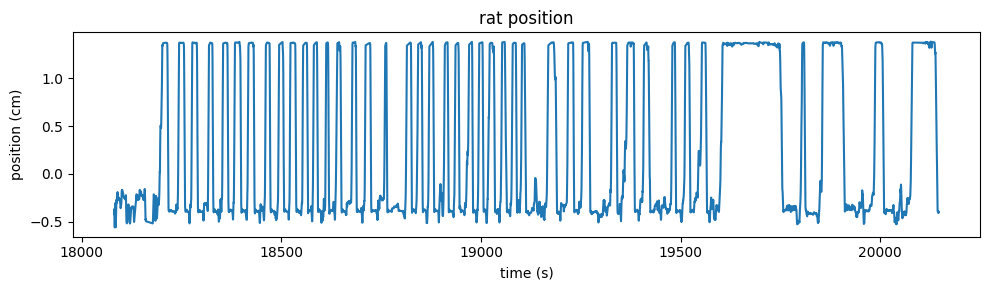

In [5]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(pos[:,0], pos[:, 1])
ax.set_title('rat position')
ax.set_xlabel('time (s)')
ax.set_ylabel('position (cm)')
fig.tight_layout()
plt.savefig('datasets/HC11/position.pdf')

### plot the activity of two example cells

In [6]:
# We define a function here that returns the approximate position for any time point
Fpos_time = interp1d(pos[:,0], pos[:,1], fill_value="extrapolate") 


Text(0, 0.5, 'position (m)')

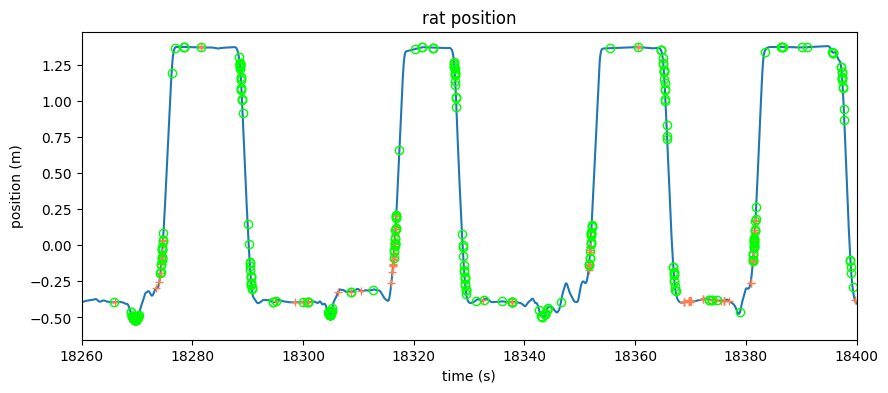

In [7]:
ii_78 = np.where(spikes[:,1] == 78)[0] # the index where the cell was active - spikes were emitted
cell_78_time = spikes[ii_78,0]
up_pos_78 = Fpos_time(cell_78_time)

ii_16 = np.where(spikes[:,1] == 16)[0] # the index where the cell was active - spikes were emitted
cell_16_time = spikes[ii_16,0]
up_pos_16 = Fpos_time(cell_16_time)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(pos[:,0], pos[:, 1])
ax.plot(cell_78_time, up_pos_78, '+', c='coral')
ax.plot(cell_16_time, up_pos_16, 'o', c='lime', fillstyle='none')
ax.set_title('rat position')
ax.set_xlabel('time (s)')
ax.set_xlim(18260, 18400)
ax.set_ylabel('position (m)')

### plot the activity of a few cells ordered by their typical activity

In [8]:
cellindex = np.array([0,  40,  47,  45,  44,  41,  52,  85,  30, 109,  87,  73,   7,
        61,  64,  90,  10, 106,  25, 111,  96, 114,  51,  42,  98,   1,
        33, 104, 116,   8,  23,  79,   5,  36,  20,  53,  99,  83,  16,
        24,  78,  43,  22,   3,  12,  29,  84,   9,  19,  18,  57, 100,
       118,  65,  38,  67, 102,  35, 112,  94,   6,  66,  69, 105, 101,
        74, 113, 117,  80,  60,  21,  15,  58, 110,  28,  34,  77,  81,
       115,  55,  91,  86,  76,  27,  97,  89, 119,  75,  26,  17,  95,
        93,  31,  46,  54,  14,  88,  62,   2,  11,  56,  68,  48, 108,
        63,  13,  49, 103,  72,  59,  70,  37,  39,  50,  82,  71, 120,
        32,  92,   4, 107])

In [9]:
# tmin = 18260
# tmax = 18285
tmin = 18310
tmax = 18325

ii_spikes = np.flatnonzero((spikes[:,0] > tmin) & (spikes[:,0] < tmax))
sp = spikes[ii_spikes,:]


ii_pos = np.flatnonzero((pos[:,0] > tmin) & (pos[:,0] < tmax))
tx = pos[ii_pos,:]


In [ ]:
distance(np.array([0, 1, 2, 3]), np.array([0, 1, 4, 5, 6]))

3

/var/folders/jw/d5_trdxs6d10y2g48wcnb0880000gn/T/ipykernel_95743/2248029194.py:26: RuntimeWarning: invalid value encountered in divide
  act_mean_spike_time /= act_spike_count


Text(0.5, 0, 'time (s)')

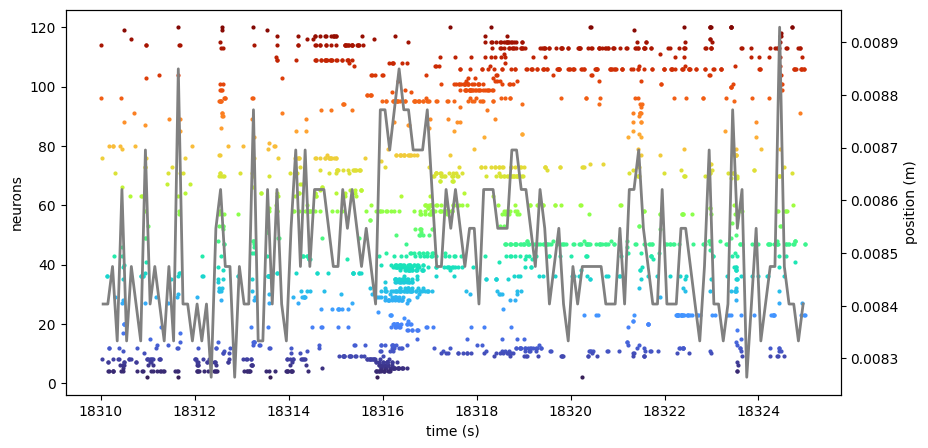

In [54]:
from Levenshtein import distance

n_cell = len(cellindex)
n_spike = sp.shape[0]

window_width_s = 0.1
window_step_s = 0.1
replay_scores = []
window_midpoints = []

act_window_start = tmin
act_window_end = act_window_start + window_width_s

while act_window_end <= tmax:
    act_spike_count = np.zeros((n_cell))
    act_mean_spike_time = np.zeros((n_cell))

    for spike_idx in range(n_spike):
        spike_time = sp[spike_idx, 0]
        spike_cell = int(sp[spike_idx, 1])
        if spike_time >= act_window_start and spike_time < act_window_end:
            act_spike_count[spike_cell] += 1
            act_mean_spike_time[spike_cell] += spike_time
        #elif spike_time >= act_window_end:
        #    break
    act_mean_spike_time /= act_spike_count
    #print(act_mean_spike_time)
    cells_spiked = np.flatnonzero(act_spike_count)
    ordering_indices = np.argsort(act_mean_spike_time[cells_spiked])
    codeword = cells_spiked[ordering_indices]
    replay_score = 1. / distance(codeword, cellindex)
    replay_scores.append(replay_score)
    window_midpoints.append(act_window_start + (act_window_end - act_window_start) / 2)
    act_window_start += window_step_s
    act_window_end += window_step_s
    
cmap = mpl.colormaps['turbo']
fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.twinx()
ax2.plot(window_midpoints, replay_scores, c='grey', zorder=1, linewidth=2)

for i_cell in np.arange(121):
    idx = np.flatnonzero(sp[:,1] == i_cell)
    if (len(idx) > 0):
        jj = np.flatnonzero(cellindex == i_cell)
        ax.scatter(sp[idx,0], np.ones(len(idx)) * jj, s=4, c=cmap(jj/121), zorder=2)
        
        # ax.scatter(sp[idx,0], np.ones(len(idx)) * i_cell, s=4, c='k')
ax2.set_ylabel('position (m)')
ax.set_ylabel('neurons')
ax.set_xlabel('time (s)')

Text(0.5, 0, 'time (s)')

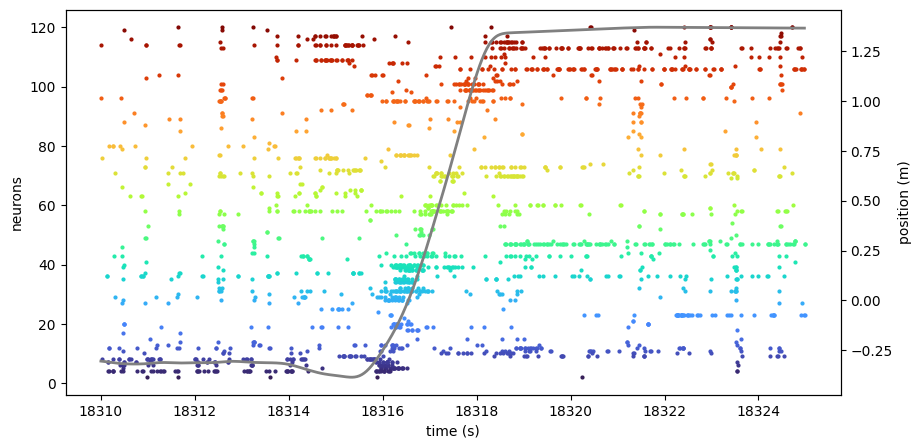

In [ ]:
cmap = mpl.colormaps['turbo']
fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.twinx()
ax2.plot(tx[:,0], tx[:,1], c='grey', zorder=1, linewidth=2)

for i_cell in np.arange(121):
    idx = np.flatnonzero(sp[:,1] == i_cell)
    if (len(idx) > 0):
        jj = np.flatnonzero(cellindex == i_cell)
        ax.scatter(sp[idx,0], np.ones(len(idx)) * jj, s=4, c=cmap(jj/121), zorder=2)
        
        # ax.scatter(sp[idx,0], np.ones(len(idx)) * i_cell, s=4, c='k')
ax2.set_ylabel('position (m)')
ax.set_ylabel('neurons')
ax.set_xlabel('time (s)')
# plt.savefig('datasets/HC11/single_run.pdf')

[Text(18312.4, 0, '18312.4'), Text(18312.6, 0, '18312.6')]

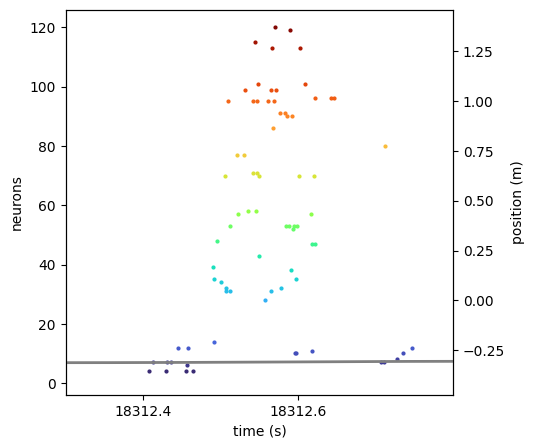

In [12]:

fig, ax = plt.subplots(figsize=(5, 5))
ax2 = ax.twinx()
ax2.plot(tx[:,0], tx[:,1], c='grey', zorder=1, linewidth=2)

for i_cell in np.arange(121):
    idx = np.flatnonzero(sp[:,1] == i_cell)
    if (len(idx) > 0):
        jj = np.flatnonzero(cellindex == i_cell)
        ax.scatter(sp[idx,0], np.ones(len(idx)) * jj, s=4, c=cmap(jj/121), zorder=2)
        
        # ax.scatter(sp[idx,0], np.ones(len(idx)) * i_cell, s=4, c='k')
ax2.set_ylabel('position (m)')
ax.set_ylabel('neurons')
ax.set_xlabel('time (s)')
ax.set_xlim(18312.3, 18312.8)
ax.set_xticks((18312.4, 18312.6))
ax.set_xticklabels((18312.4, 18312.6))

# ax.set_xlim(18323, 18324)
# plt.savefig('datasets/HC11/single_run_SPWzoom.pdf')

### Find running sections, separate up versus down

We only include data during running - so we remove all datapoints below a certain speed threshold. We also remove short segments (shorter than 20 datapoints - 0.5 s) and datapoints on the two ends of the corridor. 

In [13]:
speed_threshold = 0.05 # m/s
dt_pos = np.mean(np.diff(pos[:,0])) # the time resolution of the position recordings
speed = np.diff(pos[:,1]) / dt_pos
speed = np.hstack((speed[0], speed))
iii_run = np.logical_and(np.abs(speed) > speed_threshold, np.logical_and(pos[:,1] > -0.25, pos[:,1] < 1.25))
ii_run = np.convolve(iii_run, np.ones(20)/20, mode='same')
ii_run[ii_run < 1] = 0
i_run = np.convolve(ii_run, np.ones(20)/20, mode='same')
i_run[i_run > 0] = 1
i_down = np.logical_and(speed < 0, i_run)
i_up = np.logical_and(speed > 0, i_run)

In [14]:
speed

array([        nan,         nan,         nan, ..., -0.03906264,
       -0.0429689 , -0.04687516], shape=(80762,))

To check the results, we plot the selected sections using different colors.

Text(0, 0.5, 'position (cm)')

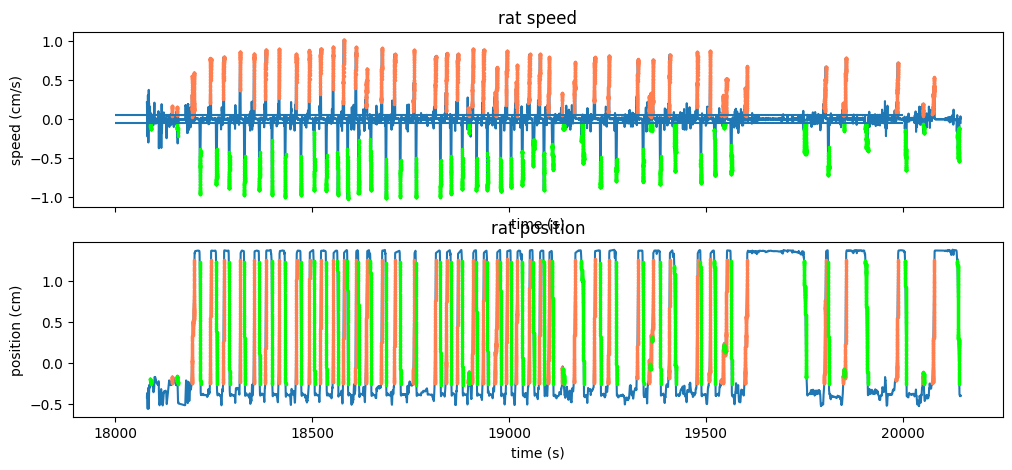

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (12, 5))
ax1.plot(pos[:,0], speed)
ax1.plot(pos[i_up,0], speed[i_up], '.', c='coral', markersize=3)
ax1.plot(pos[i_down,0], speed[i_down], '.', c='lime', markersize=3)
ax1.hlines((0.05, -0.05), 18000, 20000)
ax1.set_title('rat speed')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('speed (cm/s)')

ax2.plot(pos[:,0], pos[:,1])
ax2.plot(pos[i_up,0], pos[i_up,1], '.', c='coral', markersize=3)
ax2.plot(pos[i_down,0], pos[i_down,1], '.', c='lime', markersize=3)
ax2.set_title('rat position')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('position (cm)')

### 3. Calculating the ratemaps